In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

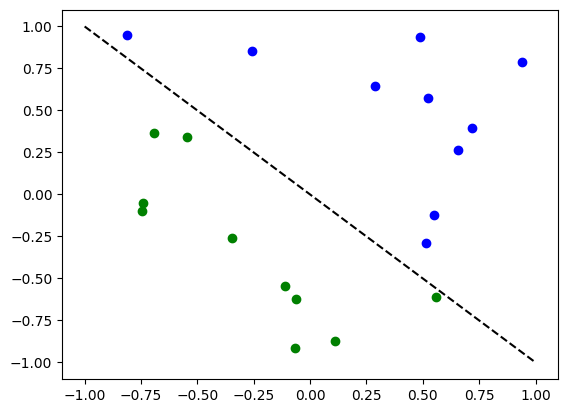

In [4]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

# EstimatorQNN Classification

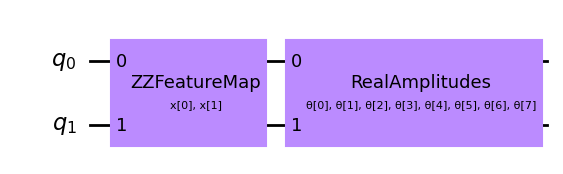

In [5]:
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [6]:
estimator_qnn = EstimatorQNN(circuit=qc)

In [7]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

In [8]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

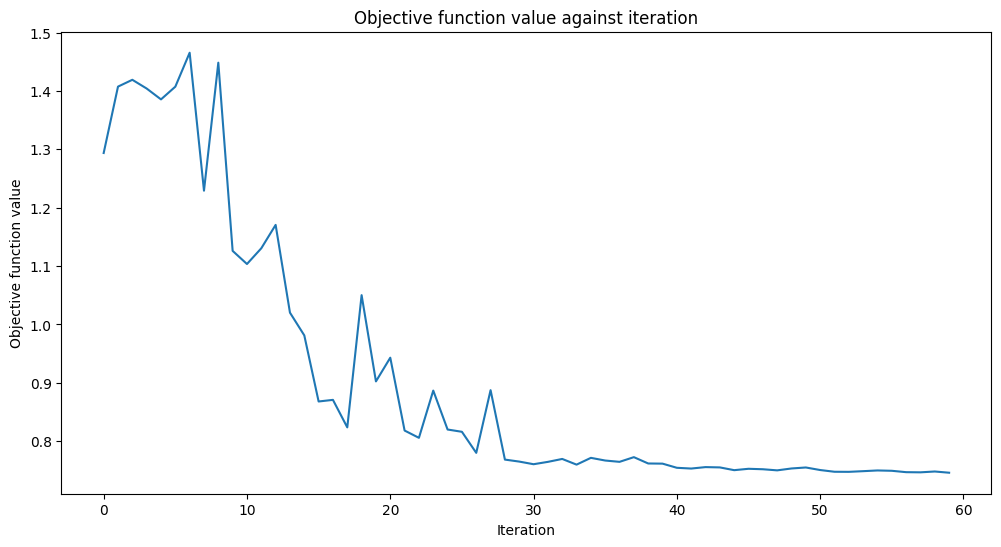

0.8

In [10]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

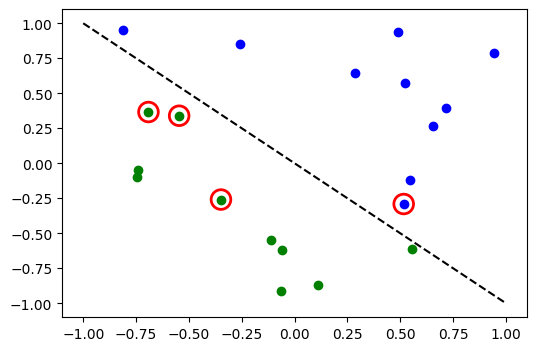

In [11]:
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [12]:
estimator_classifier.weights

array([ 0.86209107, -1.06526254, -0.10663602, -0.39086371,  1.0894299 ,
        0.59368219,  2.22731471, -1.04769663])

# SimplerQNN Classification

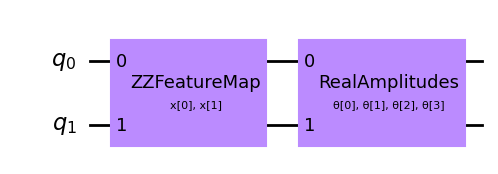

In [14]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw("mpl", style="clifford")

In [16]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [17]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [18]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

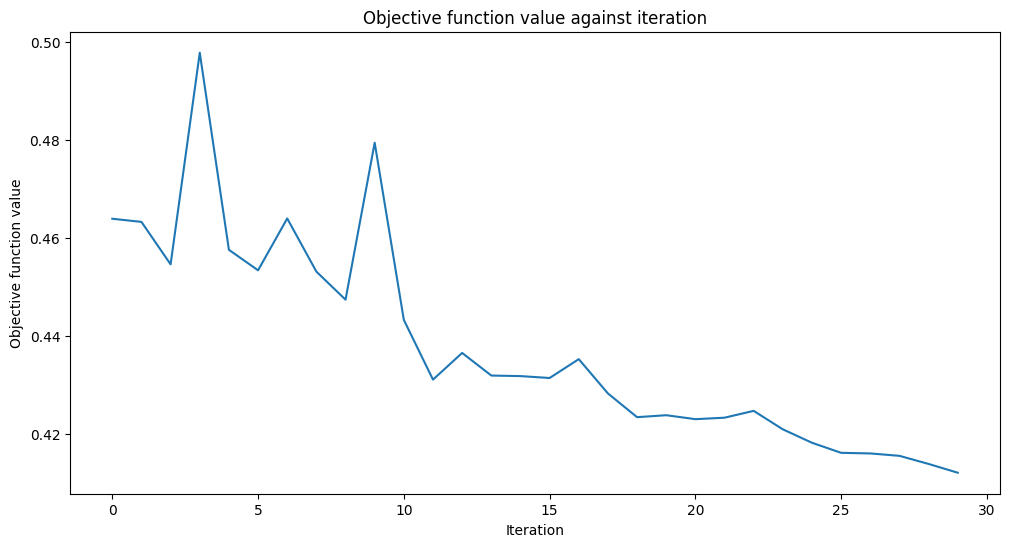

0.7

In [19]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

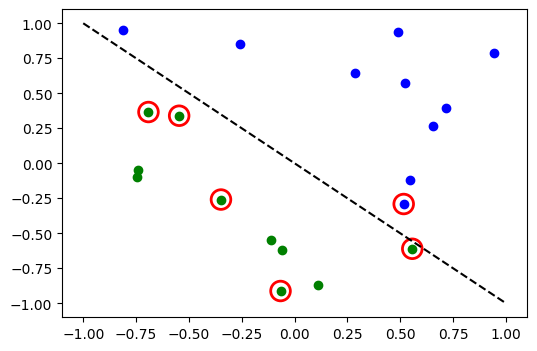

In [20]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [22]:
sampler_classifier.weights

array([ 1.67198565,  0.46045402, -0.93462862, -0.95266092])

# Variational Quantum Classifier (VQC)

In [23]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

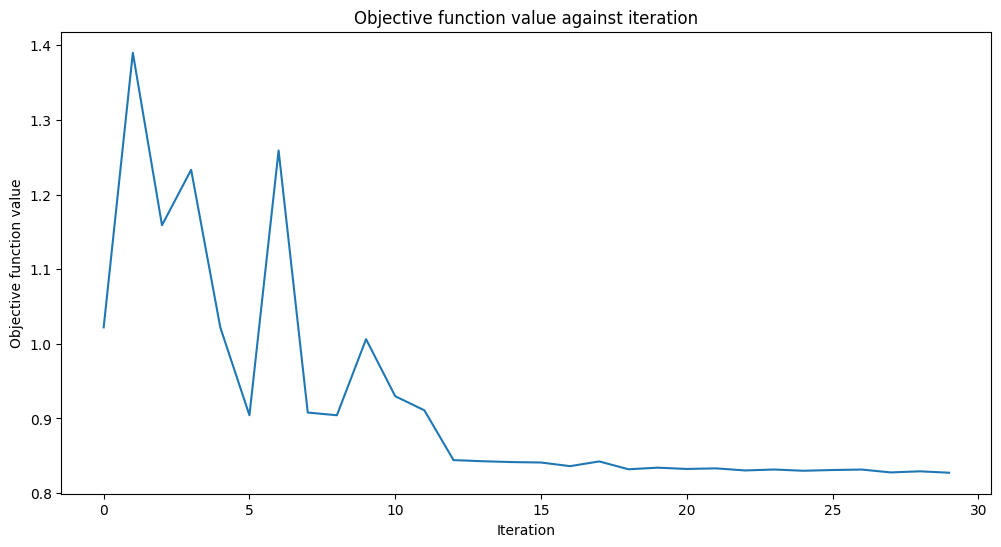

0.8

In [24]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

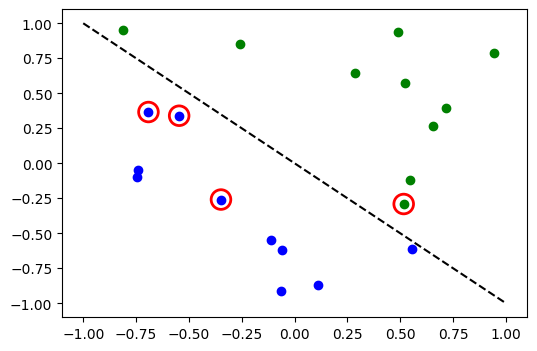

In [25]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

# Multiple Classes With VQC

In [26]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

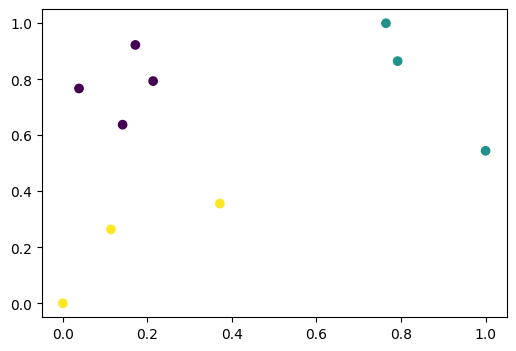

In [27]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [28]:
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


In [29]:
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

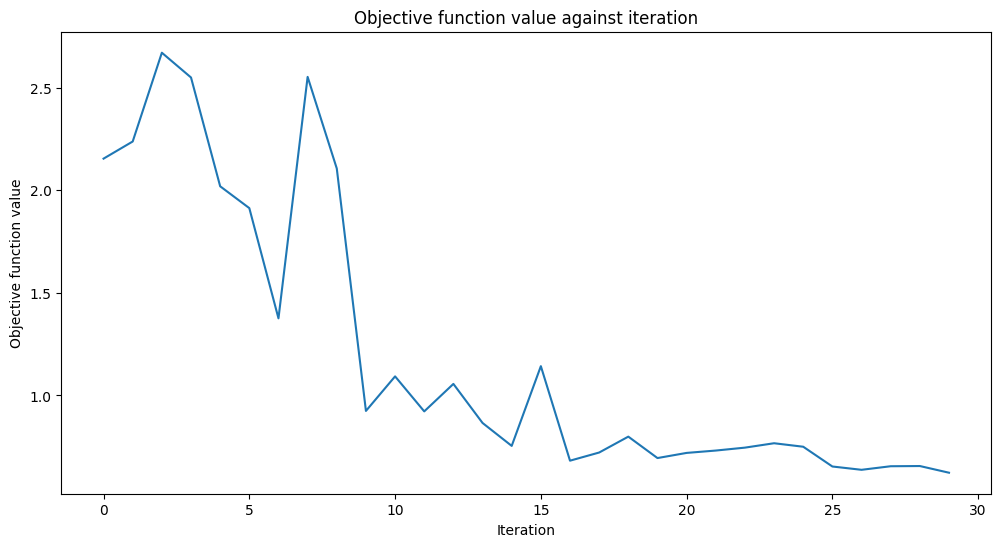

0.9

In [30]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_cat)

In [31]:
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'B']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']
